# Predicting Adverse Drug Reactions Based on Patient Demographics 

### Anthony Olvera
### CSCI 4502 Data Minning Project Fall 2018
### Data Integration, Cleaning and Preprocessing

The raw data we will process here was downloaded at https://open.fda.gov/tools/downloads/ and inflated to a total of 788 json files. The files take a total of roughley 203 GB of space which will be best managed in a relational database as opposed to files. My goal is to first load the data into a dataframe, filter and reduce by dropping irrelevent attributes follwed by dropping all relevent entries with one or more null values. I will then proceed to preprocess the data by eliminating outliers and normalizing where appropriate. after all cleaning and preprocessing I will store the data as a single postgre sql relational database where it can be accessed in the future for all remaining work on the project.     

In [1]:
# Import all nessasary utilities
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import scipy.stats as stats
import json

In [2]:
# test reading a json file and output result
data = json.load(open('G:\drug-event-0001-of-0004.json'))
patient_info = json_normalize(data['results'])
df = pd.DataFrame(patient_info)

In [3]:
# what are the attributes
list(df)

['companynumb',
 'fulfillexpeditecriteria',
 'patient.drug',
 'patient.patientdeath.patientdeathdate',
 'patient.patientdeath.patientdeathdateformat',
 'patient.patientonsetage',
 'patient.patientonsetageunit',
 'patient.patientsex',
 'patient.patientweight',
 'patient.reaction',
 'primarysource',
 'primarysource.qualification',
 'primarysource.reportercountry',
 'receiptdate',
 'receiptdateformat',
 'receivedate',
 'receivedateformat',
 'receiver',
 'safetyreportid',
 'sender.senderorganization',
 'serious',
 'seriousnesscongenitalanomali',
 'seriousnessdeath',
 'seriousnessdisabling',
 'seriousnesshospitalization',
 'seriousnesslifethreatening',
 'seriousnessother',
 'transmissiondate',
 'transmissiondateformat']

In [4]:
# Most intersting attibutes include all patient related attributes, primary source, seriousness measures
# and transmission information, all other attributes will be droped.
df = df.drop(columns = ['companynumb', 'fulfillexpeditecriteria', 'primarysource','receiptdate',
                        'receiptdateformat', 'receivedateformat', 'receiver',
                       'safetyreportid','sender.senderorganization','transmissiondateformat',
                       'patient.patientdeath.patientdeathdateformat','patient.patientonsetageunit'])
df.head()

,patient.drug,patient.patientdeath.patientdeathdate,patient.patientonsetage,patient.patientsex,patient.patientweight,patient.reaction,primarysource.qualification,primarysource.reportercountry,receivedate,serious,seriousnesscongenitalanomali,seriousnessdeath,seriousnessdisabling,seriousnesshospitalization,seriousnesslifethreatening,seriousnessother,transmissiondate
0,"[{'drugstartdateformat': '102', 'medicinalprod...",NaN,NaN,NaN,NaN,[{'reactionmeddrapt': 'DEATH'}],NaN,AUSTRIA,20101115,1,NaN,1,NaN,NaN,NaN,NaN,20110411
1,"[{'drugstartdateformat': '102', 'medicinalprod...",NaN,NaN,2,NaN,"[{'reactionmeddrapt': 'ABORTION SPONTANEOUS'},...",3,UNITED KINGDOM,20090803,1,NaN,NaN,NaN,NaN,NaN,1,20100115
2,"[{'drugstartdateformat': '102', 'medicinalprod...",20040322,66,1,78.9259,[{'reactionmeddrapt': 'INTERSTITIAL LUNG DISEA...,1,UNITED STATES,20061213,1,NaN,1,NaN,NaN,NaN,NaN,20070707
3,"[{'drugstartdateformat': '102', 'medicinalprod...",NaN,61,2,49.4421,"[{'reactionmeddrapt': 'ABDOMINAL DISTENSION'},...",NaN,UNITED STATES,20061213,1,NaN,NaN,NaN,NaN,NaN,1,20070707
4,"[{'medicinalproduct': 'IRESSA', 'drugindicatio...",NaN,77,2,NaN,[{'reactionmeddrapt': 'ANAEMIA'}],1,UNITED STATES,20061213,1,NaN,NaN,NaN,NaN,NaN,1,20070707


In [5]:
# it can be seen that patient.drug and patient.reaction need to be expanded
# create two new data frames for each attribute filter/reduce then merge with original 

# create a new reaction dataframe
data = []
for row in range(len(df['patient.reaction'])):
    reactions = []
    for list_index in range(len(df['patient.reaction'][row])):
        reactions.append(df['patient.reaction'][row][list_index]['reactionmeddrapt'])
    data.append(reactions)
reaction = pd.DataFrame(data)

# create a new drug dataframe 
data = []
for row in range(len(df['patient.drug'])):
    drugs = []
    for list_index in range(len(df['patient.drug'][row])):
        drugs.append(df['patient.drug'][row][list_index]['medicinalproduct'])
    data.append(drugs)
drug = pd.DataFrame(data)

# give columns appropriate names  
for column in reaction.columns:
    reaction = reaction.rename(columns = {column : 'Reaction_' + str(column)})
    
for column in drug.columns:
    drug = drug.rename(columns = {column : 'Drug_' + str(column)})
    

In [6]:
# Now drop the nested columns and merge with new dataframes
df = df.drop(columns = ['patient.drug','patient.reaction'])

patient_info = pd.concat([df, drug, reaction], axis=1, join='inner')

#some more column filtering
patient_info = patient_info[['patient.patientonsetage',	'patient.patientsex','patient.patientweight', 
                             'primarysource.reportercountry','serious','transmissiondate', 
                             'receivedate','Drug_0', 'Reaction_0', 'Reaction_1', 'Reaction_2']]


In [7]:
# check column datatypes
patient_info.dtypes

patient.patientonsetage          object
patient.patientsex               object
patient.patientweight            object
primarysource.reportercountry    object
serious                          object
transmissiondate                 object
receivedate                      object
Drug_0                           object
Reaction_0                       object
Reaction_1                       object
Reaction_2                       object
dtype: object

In [8]:
# convert columns to numeric data
patient_info['patient.patientonsetage'] = pd.to_numeric(df['patient.patientonsetage'])
patient_info['patient.patientweight'] = pd.to_numeric(df['patient.patientweight'])
patient_info['patient.patientsex'] = pd.to_numeric(df['patient.patientsex'])

# Now eliminate outliers on age and weight
age_q1 = patient_info['patient.patientonsetage'].quantile(0.25)
age_q3 = patient_info['patient.patientonsetage'].quantile(0.75)
age_IQR = age_q3 - age_q1
weight_q1 = patient_info['patient.patientweight'].quantile(0.25)
weight_q3 = patient_info['patient.patientweight'].quantile(0.75)
weight_IQR = weight_q3 - weight_q1
age_upperbound = age_q3 + 1.5*age_IQR
age_lowerbound = age_q1 - 1.5*age_IQR
weight_upperbound = weight_q3 + 1.5*weight_IQR
weight_lowerbound = weight_q3 - 1.5*weight_IQR
patient_info = patient_info.drop(
    patient_info[patient_info['patient.patientonsetage'] < age_lowerbound].index)
patient_info = patient_info.drop(
    patient_info[patient_info['patient.patientonsetage'] > age_upperbound].index)
patient_info = patient_info.drop(
    patient_info[patient_info['patient.patientweight'] < weight_lowerbound].index)
patient_info = patient_info.drop(
    patient_info[patient_info['patient.patientweight'] > weight_upperbound].index)


In [9]:
# drop all rows with null patient demographic info 
patient_info = patient_info.dropna(subset=['patient.patientonsetage', 'patient.patientsex',
                                                                             'patient.patientweight',])
# drop rows with patientsex = 0
patient_info = patient_info[patient_info['patient.patientsex'] != 0]

# make sure we will still have millions of data points  
patient_info.count()

patient.patientonsetage          2463
patient.patientsex               2463
patient.patientweight            2463
primarysource.reportercountry      36
serious                          2463
transmissiondate                 2463
receivedate                      2463
Drug_0                           2463
Reaction_0                       2463
Reaction_1                       1742
Reaction_2                       1258
dtype: int64

In [10]:
# Preview of the data
patient_info.head()

,patient.patientonsetage,patient.patientsex,patient.patientweight,primarysource.reportercountry,serious,transmissiondate,receivedate,Drug_0,Reaction_0,Reaction_1,Reaction_2
2,66.0,1.0,78.9259,UNITED STATES,1,20070707,20061213,IRESSA,INTERSTITIAL LUNG DISEASE,None,None
3,61.0,2.0,49.4421,UNITED STATES,1,20070707,20061213,IRESSA,ABDOMINAL DISTENSION,BLOOD PRESSURE DECREASED,CANDIDIASIS
5,67.0,2.0,74.8435,UNITED STATES,1,20070707,20061213,IRESSA,CHILLS,DYSPNOEA,FATIGUE
14,56.0,1.0,75.7507,UNITED STATES,1,20070707,20061213,IRESSA,INTERSTITIAL LUNG DISEASE,None,None
17,66.0,1.0,72.5755,UNITED STATES,2,20070707,20061212,CASODEX,BLOOD CHOLESTEROL INCREASED,None,None


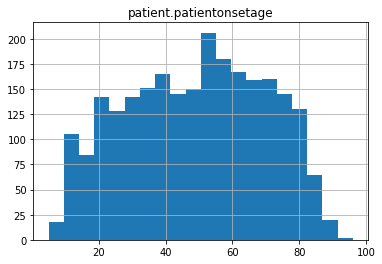

In [11]:
# check to see if patient demographic info is normally distributed or skewed
patient_info.hist(column = 'patient.patientonsetage', bins=20);

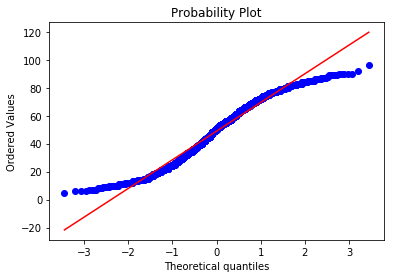

In [17]:
# verify with qq plot
stats.probplot(patient_info['patient.patientonsetage'], dist = 'norm', plot = plt,);

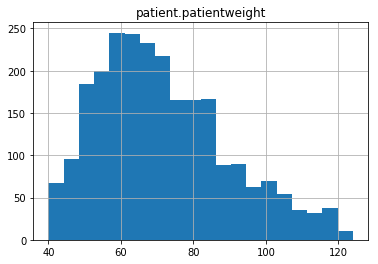

In [13]:
patient_info.hist(column = 'patient.patientweight', bins=20);

SkewtestResult(statistic=11.766181724799404, pvalue=5.83041859092924e-32)

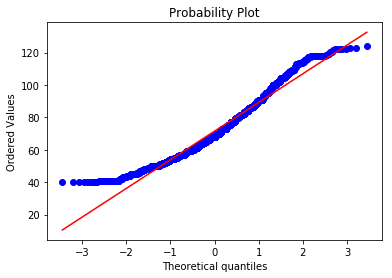

In [23]:
stats.probplot(patient_info['patient.patientweight'], dist = 'norm', plot = plt,);

# measure and test skew
weight_skew = stats.skew(patient_info['patient.patientweight'])
weight_skew
stats.skewtest(patient_info['patient.patientweight'])


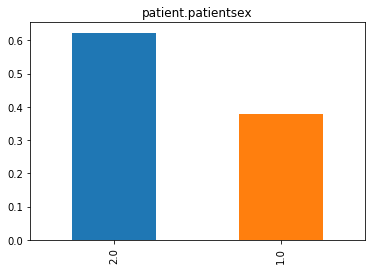

In [14]:
# Plot bar chart of percentage of male vs female, male = 1, female = 2
patient_info['patient.patientsex'].value_counts(1).plot(kind = 'bar', title = 'patient.patientsex');

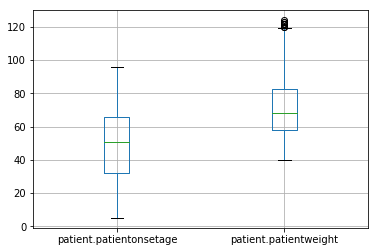

In [15]:
# Weight looks slightley right skewed, make box plot for comparison
boxplot = patient_info.boxplot(column=['patient.patientonsetage', 'patient.patientweight']);